In [1]:
import CUDA

In [2]:
include("main.jl")

draw_plots (generic function with 1 method)

In [3]:
test_image_path = "/home/gsoykan/Desktop/comp541/DeepLabCut/examples/openfield-Pranav-2018-10-30/labeled-data/m4s1/img0000.png"
image_folder_path = "/home/gsoykan/Desktop/comp541/DeepLabCut/examples/openfield-Pranav-2018-10-30/labeled-data/m4s1"
label_data_path = "/home/gsoykan/Desktop/comp541/DeepLabCut/examples/openfield-Pranav-2018-10-30/labeled-data/m4s1/CollectedData_Pranav.csv"
image_dim_x = 640
image_dim_y = 480
number_of_categories = 4
minibatch_size = 16
test_set_size = 16
dev_set_size = 16
resized_image_dim_x = 32
resized_image_dim_y = 24

24

In [4]:
X, Y = read_all_data(label_data_path, image_dim_x, image_dim_y, number_of_categories; 
        resized_image_dim_x=resized_image_dim_x,
        resized_image_dim_y=resized_image_dim_y  )

(Float32[0.27124184 0.29346406 0.28169936; 0.27124184 0.28431374 0.28169936; … ; 0.29346406 0.28300655 0.275817; 0.29346406 0.28169936 0.275817]

Float32[0.26928106 0.28627452 0.27058825; 0.26928106 0.28692812 0.27058825; … ; 0.28627452 0.28300655 0.2784314; 0.28627452 0.27058825 0.2784314]

Float32[0.28300655 0.29803923 0.275817; 0.28300655 0.3013072 0.275817; … ; 0.29803923 0.28692812 0.2901961; 0.29803923 0.275817 0.2901961]

...

Float32[0.29738563 0.29803923 0.29803923; 0.29738563 0.29803923 0.29803923; … ; 0.29803923 0.29346406 0.29738563; 0.29803923 0.29803923 0.29738563]

Float32[0.1379085 0.14183007 0.1875817; 0.1379085 0.14183007 0.1875817; … ; 0.14183007 0.19084968 0.21503268; 0.14183007 0.1875817 0.21503268]

Float32[0.18366013 0.18366013 0.19150327; 0.18366013 0.18366013 0.19150327; … ; 0.18366013 0.1875817 0.18431373; 0.18366013 0.19150327 0.18431373]

Float32[0.35882354 0.37058824 0.35686275; 0.35882354 0.37254903 0.35686275; … ; 0.37058824 0.3627451 0.3529412; 0.3705882

In [32]:
# TODO: improve this reshaping process
reshaped_X = reshape(X, (resized_image_dim_x, resized_image_dim_y, 3, 116))
#reshaped_Y = reshape(Y, (640 * 480, 116 ))
reshaped_Y = reshape(Y, (8, 116 ))

x_train = reshaped_X[:,:,:, test_set_size + dev_set_size + 1 : end]
x_dev = reshaped_X[:,:,:, test_set_size + 1: test_set_size + dev_set_size]
x_test = reshaped_X[:,:,:, begin : test_set_size ]

y_train = reshaped_Y[:, test_set_size + dev_set_size + 1: end]
y_dev = reshaped_Y[:, test_set_size + 1 : test_set_size + dev_set_size]
y_test = reshaped_Y[:, begin : test_set_size ]

println(size(y_test))
println(size(y_dev))
println(size(y_train))

(8, 16)
(8, 16)
(8, 84)


In [33]:
# TODO: Make this consistent for all array types now it just works for KnetArrays
atype = CUDA.functional() ? KnetArray{Float32} : Array{Float32}
#atype = Array{Float32}

KnetArray{Float32,N} where N

In [34]:
Knet.atype() = atype

In [35]:
dtrn = minibatch(x_train, y_train, minibatch_size; xsize = (resized_image_dim_x, resized_image_dim_y, 3, :), xtype=atype)
dtst = minibatch(x_test, y_test, minibatch_size; xsize = (resized_image_dim_x, resized_image_dim_y, 3, :), xtype=atype)
#dtst = dtrn

1-element Data{Tuple{KnetArray{Float32,N} where N,KnetArray{Float32,N} where N}}

In [36]:
# loss(w,x,y) = sumabs2(y - predict(w,x)) / size(y,2)
function loss(x,y) 
    sum(abs2, y - x) / size(y, 2)
end

loss (generic function with 1 method)

In [55]:
lenet = Chain(Conv2(5,5,3,20), 
                Conv2(5,5,20,50), 
                Dense(750,100,pdrop=0.3), 
                Dense(100,8,sigm,pdrop=0.3); loss=loss)
summary.(l.w for l in lenet.layers)

4-element Array{String,1}:
 "5×5×3×20 Param{KnetArray{Float32,4}}"
 "5×5×20×50 Param{KnetArray{Float32,4}}"
 "100×750 Param{KnetArray{Float32,2}}"
 "8×100 Param{KnetArray{Float32,2}}"

In [63]:
GC.gc(true)

In [64]:
CUDA.memory_status()

Effective GPU memory usage: 83.18% (4.937 GiB/5.935 GiB)
CUDA allocator usage: 3.970 GiB
binned usage: 2.720 GiB (250.328 KiB allocated, 2.720 GiB cached)
Discrepancy of 1.250 GiB between memory pool and allocator!


In [66]:
CUDA.reclaim()

2916049920

┣████████████████████┫ [100.00%, 10000/10000, 00:14/00:14, 734.36i/s] 


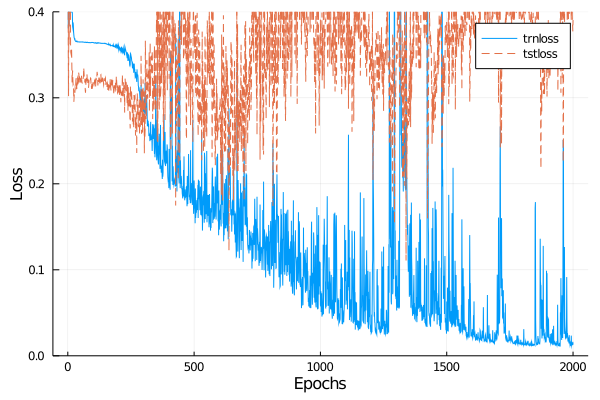

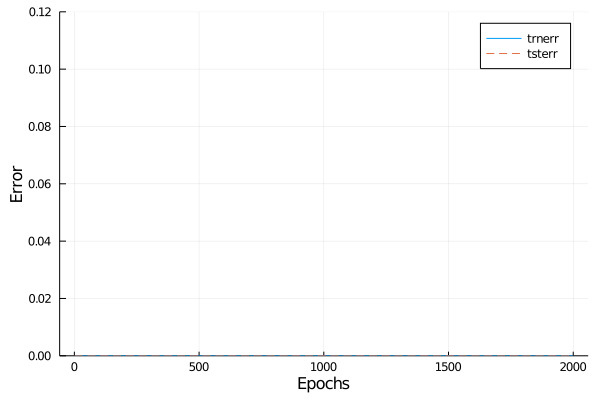

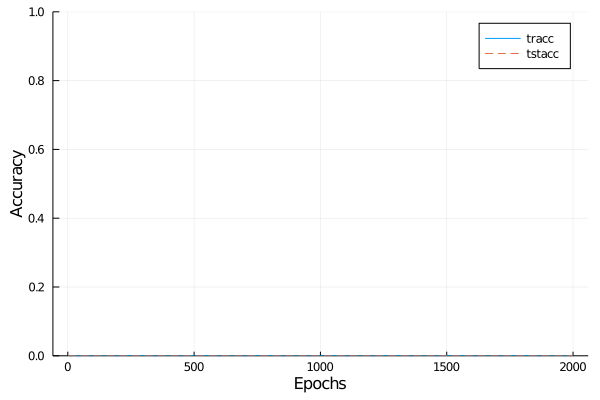

In [59]:
lenet_results = trainresults("lenet_proj.jld2", lenet, dtrn, dtst, 2000, 0.15; accuracy_func=nothing, error_func=nothing);
draw_plots(lenet_results)

In [60]:
firstx, firsty = first(dtrn)

(K32(32,24,3,16)[0.8385621⋯], K32(8,16)[0.15452343⋯])

In [67]:
res_first_x = lenet(firstx)
tt1 = res_first_x[:, 3]
ty1 = firsty[: ,3]

hcat(tt1, ty1)

8×2 KnetArray{Float32,2}:
 0.0497188  0.0400313
 0.935685   0.910596
 0.0645664  0.0520422
 0.961992   0.92981
 0.056327   0.0480391
 0.940968   0.893515
 0.235505   0.225781
 0.983902   0.913798

In [68]:
lenet(dtrn)

0.0129452f0

In [69]:
lenet(dtst)

0.39039063f0